In [1]:
from __future__ import print_function

import os
import numpy as np

from skimage.io import imsave, imread

data_path = 'raw/'

image_rows = 420
image_cols = 580

In [2]:
def create_train_data():
    train_data_path = os.path.join(data_path, 'train')
    images = os.listdir(train_data_path)
    total = len(images) / 2

    imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
    imgs_mask = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        if 'mask' in image_name:
            continue
        image_mask_name = image_name.split('.')[0] + '_mask.tif'
        img = imread(os.path.join(train_data_path, image_name), as_grey=True)
        img_mask = imread(os.path.join(train_data_path, image_mask_name), as_grey=True)

        img = np.array([img])
        img_mask = np.array([img_mask])

        imgs[i] = img
        imgs_mask[i] = img_mask

        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_train.npy', imgs)
    np.save('imgs_mask_train.npy', imgs_mask)
    print('Saving to .npy files done.')


def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train


def create_test_data():
    train_data_path = os.path.join(data_path, 'test')
    images = os.listdir(train_data_path)
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols), dtype=np.uint8)
    imgs_id = np.ndarray((total, ), dtype=np.int32)

    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    for image_name in images:
        img_id = int(image_name.split('.')[0])
        img = imread(os.path.join(train_data_path, image_name), as_grey=True)

        img = np.array([img])

        imgs[i] = img
        imgs_id[i] = img_id

        if i % 100 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_test.npy', imgs)
    np.save('imgs_id_test.npy', imgs_id)
    print('Saving to .npy files done.')


def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_id = np.load('imgs_id_test.npy')
    return imgs_test, imgs_id


In [3]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
K.set_image_data_format('channels_last') 

In [5]:
img_rows = 192
img_cols = 192

smooth = 1.

In [6]:
from keras import optimizers
from keras.models import Model
from keras.layers import Dropout, Lambda
from keras.layers import Input, average
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import ZeroPadding2D, Cropping2D
from keras import backend as K
from keras.layers import BatchNormalization

In [11]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn


def crop(tensors):
    '''
    List of 2 tensors, the second tensor having larger spatial dimensions.
    '''
    h_dims, w_dims = [], []
    for t in tensors:
        b, h, w, d = K.get_variable_shape(t)
        h_dims.append(h)
        w_dims.append(w)
    crop_h, crop_w = (h_dims[1] - h_dims[0]), (w_dims[1] - w_dims[0])
    rem_h = crop_h % 2
    rem_w = crop_w % 2
    crop_h_dims = (crop_h // 2, crop_h // 2 + rem_h)
    crop_w_dims = (crop_w // 2, crop_w // 2 + rem_w)
    cropped = Cropping2D(cropping=(crop_h_dims, crop_w_dims))(tensors[1])
    
    return cropped


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def get_unet():
    

In [12]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

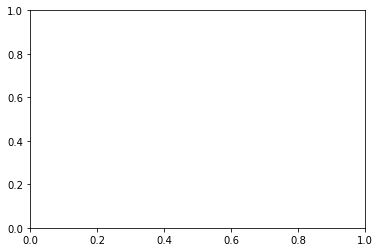

In [13]:
import matplotlib.pyplot as plt
plt.ticklabel_format(style='plain',axis='x',useOffset=False)
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    print(imgs_train.shape)
    history = model.fit(imgs_train, imgs_mask_train, batch_size=32, nb_epoch=25, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])
    print(history.history.keys())
    print(model.summary())
    print(history.history.keys())
    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'], loc='best')
    plt.savefig('dice.png')
    plt.show()
    
    
    plt.plot(history.history['jaccard_coef'])
    plt.plot(history.history['val_jaccard_coef'])
    #plt.title('Jaccard Coefficient')
    plt.ylabel('Jaccard Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'], loc='best')
    plt.savefig('jaccard.png')
    plt.show()
    
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    #plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.savefig('accuracy.png')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.savefig('loss.png')
    plt.show()
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_id_test = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, imgs_id_test):
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)
        
    return history


------------------------------
Loading and preprocessing train data...
------------------------------


/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
(5635, 192, 192, 1)


/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4508 samples, validate on 1127 samples
Epoch 1/25
4508/4508 [==============================] - 81s - loss: -0.3195 - acc: 0.9369 - dice_coef: 0.3195 - jaccard_coef: 0.1236 - val_loss: -0.4590 - val_acc: 0.9884 - val_dice_coef: 0.4590 - val_jaccard_coef: 0.1513
Epoch 2/25
4508/4508 [==============================] - 79s - loss: -0.5176 - acc: 0.9871 - dice_coef: 0.5176 - jaccard_coef: 0.1934 - val_loss: -0.5263 - val_acc: 0.9859 - val_dice_coef: 0.5263 - val_jaccard_coef: 0.2108
Epoch 3/25
4508/4508 [==============================] - 78s - loss: -0.5603 - acc: 0.9885 - dice_coef: 0.5603 - jaccard_coef: 0.2096 - val_loss: -0.5266 - val_acc: 0.9901 - val_dice_coef: 0.5266 - val_jaccard_coef: 0.1720
Epoch 4/25
4508/4508 [==============================] - 77s - loss: -0.5887 - acc: 0.9893 - dice_coef: 0.5887 - jaccard_coef: 0.2191 - val_loss: -0.5652 - val_acc: 0.9897 - val_dice_coef: 0.5652 - val_jaccard_coef: 0.2007
Epoch 5/25
4508/4508 [==============================] - 77s - lo

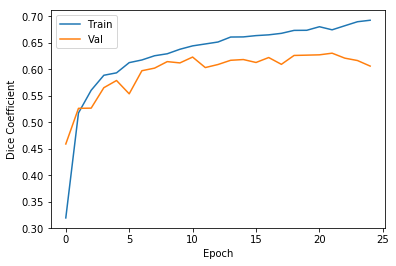

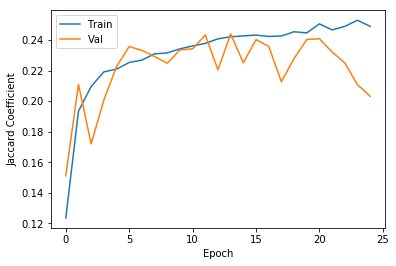

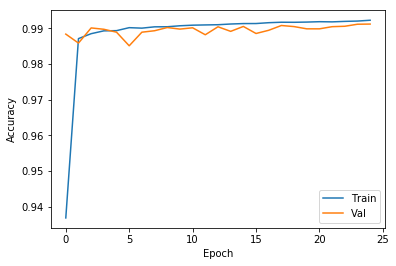

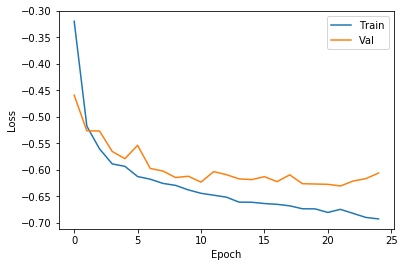

------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
5508/5508 [==============================] - 30s    
------------------------------
Saving predicted masks to files...
------------------------------


/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2720_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4752_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5091_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4277_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/147_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2832_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5224_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3790_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2637_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/669_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1773_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2394_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1336_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2986_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4053_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2363_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4330_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3279_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5375_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1591_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3079_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2259_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1810_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3058_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/402_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4018_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4841_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4426_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/163_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2031_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2414_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4557_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/675_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/947_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3728_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virt

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1833_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4424_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/156_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/847_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2064_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virt

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2534_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3607_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4907_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1427_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4771_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2358_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/643_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3422_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5272_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4656_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/225_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2109_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4837_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3184_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/484_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virt

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2071_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/653_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4042_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5507_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/201_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virt

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5301_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2112_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2771_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1180_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/383_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4007_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2002_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5135_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5072_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3353_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3327_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2042_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2563_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4238_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2859_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1637_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/935_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1160_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4862_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/835_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virt

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5270_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1692_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5248_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4765_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1378_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5030_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4867_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5317_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3271_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4419_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1557_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1125_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2154_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3205_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4709_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1593_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4520_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2713_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1750_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4938_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1458_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2334_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1210_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5457_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5258_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3660_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1776_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5408_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1078_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2122_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3175_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3385_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5508_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1205_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1283_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4323_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1866_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4334_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4077_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5227_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1567_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3840_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/663_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3004_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5418_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2137_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4514_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1515_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3923_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2729_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1897_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2106_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1978_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5378_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3854_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3856_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/877_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/447_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5136_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4782_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virt

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4826_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3203_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/425_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4140_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1347_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/57_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/612_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3471_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2342_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5056_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtu

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/699_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3767_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2739_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/125_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2384_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virt

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4498_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4471_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4406_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/5166_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1258_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1946_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1061_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/703_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2472_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3241_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vir

/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/4816_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3849_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/1237_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/2725_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-virtualenvs/tensoflow1.2/lib/python3.4/site-packages/skimage/io/_io.py:132: UserWarning: preds/3314_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/python-vi

In [14]:
history= train_and_predict()

In [15]:
history

In [18]:
history(dice_coef)

TypeError: 'History' object is not callable